In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
from tensorflow.keras import metrics
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype('float32') / 255.
    array = np.reshape(array, (len(array), 100, 100, 1))  # Resize to 100x100 for chest images
    return array


In [ ]:
def display_pairs(images, labels, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - images: An array containing the pair of images.
        - labels: An array containing the corresponding label (0 if both
            pairs are different, and 1 if both pairs are the same.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(images[:n, 0], images[:n, 1])):
        label = int(labels[:n][i][0])

        text = "Label"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Prediction"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(1, -3 ,f"{text}: {label}", style="italic", bbox={
            "facecolor": color,
            "pad": 4
        })

        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
def plot_history(history):
    """
    Plots the training and validation loss.
    """

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
def generate_pairs(images, labels):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    x_pairs = []
    y_pairs = []

    for i in range(len(images)):
        label = labels[i]

        j = np.random.choice(np.where(labels == label)[0])
        x_pairs.append([images[i], images[j]])
        y_pairs.append([1])

        k = np.random.choice(np.where(labels != label)[0])
        x_pairs.append([images[i], images[k]])
        y_pairs.append([0])

    indices = np.arange(len(x_pairs))
    np.random.shuffle(indices)

    return np.array(x_pairs)[indices], np.array(y_pairs)[indices]

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load chest images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(100, 100), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

TRAIN_DIR = '/content/drive/MyDrive/dataset/Train'
VALIDATION_DIR = '/content/drive/MyDrive/dataset/Validation'
TEST_DIR = '/content/drive/MyDrive/dataset/Test'

covid_train = load_images_from_folder(os.path.join(TRAIN_DIR, 'covid'))
normal_train = load_images_from_folder(os.path.join(TRAIN_DIR, 'normal'))
pneumonia_train = load_images_from_folder(os.path.join(TRAIN_DIR, 'pneumonia'))
tuberculosis_train = load_images_from_folder(os.path.join(TRAIN_DIR, 'tuberculosis'))
lung_opacity_train = load_images_from_folder(os.path.join(TRAIN_DIR, 'lung_opacity'))

covid_val = load_images_from_folder(os.path.join(VALIDATION_DIR, 'covid'))
normal_val = load_images_from_folder(os.path.join(VALIDATION_DIR, 'normal'))
pneumonia_val = load_images_from_folder(os.path.join(VALIDATION_DIR, 'pneumonia'))
tuberculosis_val = load_images_from_folder(os.path.join(VALIDATION_DIR, 'tuberculosis'))
lung_opacity_val = load_images_from_folder(os.path.join(VALIDATION_DIR, 'lung_opacity'))

covid_test = load_images_from_folder(os.path.join(TEST_DIR, 'covid'))
normal_test = load_images_from_folder(os.path.join(TEST_DIR, 'normal'))
pneumonia_test = load_images_from_folder(os.path.join(TEST_DIR, 'pneumonia'))
tuberculosis_test = load_images_from_folder(os.path.join(TEST_DIR, 'tuberculosis'))
lung_opacity_test = load_images_from_folder(os.path.join(TEST_DIR, 'lung_opacity'))

x_train = np.concatenate((covid_train, normal_train, pneumonia_train, tuberculosis_train, lung_opacity_train))
y_train = np.concatenate((np.zeros(len(covid_train)), np.ones(len(normal_train)), np.ones(len(pneumonia_train))*2, np.ones(len(tuberculosis_train))*3, np.ones(len(lung_opacity_train))*4))

x_val = np.concatenate((covid_val, normal_val, pneumonia_val, tuberculosis_val, lung_opacity_val))
y_val = np.concatenate((np.zeros(len(covid_val)), np.ones(len(normal_val)), np.ones(len(pneumonia_val))*2, np.ones(len(tuberculosis_val))*3, np.ones(len(lung_opacity_val))*4))

x_test = np.concatenate((covid_test, normal_test, pneumonia_test, tuberculosis_test, lung_opacity_test))
y_test = np.concatenate((np.zeros(len(covid_test)), np.ones(len(normal_test)), np.ones(len(pneumonia_test))*2, np.ones(len(tuberculosis_test))*3, np.ones(len(lung_opacity_test))*4))

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)

print(f"Train: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Test: {len(x_test)}")


Train: 500
Validation: 500
Test: 1000


In [ ]:
x_pairs_train, y_pairs_train = generate_pairs(x_train, y_train)
x_pairs_val, y_pairs_val = generate_pairs(x_val, y_val)
x_pairs_test, y_pairs_test = generate_pairs(x_test, y_test)

ValueError: ignored

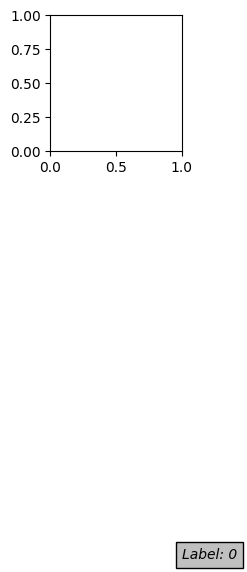

In [ ]:
display_pairs(x_pairs_train, y_pairs_train)

In [ ]:
def norm(features):
    """
    Computes the euclidean norm of the two feature vectors generated
    by the twins of the Siamese network.
    """
    return tf.norm(features[0] - features[1], axis=1, keepdims=True)


def accuracy(y_true, y_pred):
    """
    Computes the accuracy of the predictions.
    """

    # Notice that `y_true` is 0 whenever two images are not the same and 1
    # otherwise, but `y_pred` is the opposite. The closer `y_pred` is to 0,
    # the shorter the distance between both images, therefore the more likely
    # it is that they are the same image. To correctly compute the accuracy we
    # need to substract `y_pred` from 1 so both vectors are comparable.
    return metrics.binary_accuracy(y_true, 1 - y_pred)


def contrastive_loss(y_true, y_pred):
    """
    Computes the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping," 2005.
    """

    margin = 1
    y_true = tf.cast(y_true, y_pred.dtype)

    # The original formula proposed by Yann LeCunn et al. assumes that Y is 0
    # if both images are similar and 1 otherwise. Our implementation (where Y is
    # `y_true`) is the opposite, hence the modification to the formula below.
    loss = y_true / 2 * K.square(y_pred) + (1 - y_true) / 2 \
                  * K.square(K.maximum(0.0, margin - y_pred))

    return loss

In [ ]:
def siamese_twin():
    """
    Creates the subnetwork that represents each one of the twins of the
    Siamese network.
    """

    inputs = layers.Input((28, 28, 1))

    x = layers.Conv2D(128, (2, 2), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(128, (2, 2), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(64, (2, 2), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # We don't want any activation function on the final layer. This layer
    # will contain the embedding for the input image.
    outputs = layers.Dense(128, activation=None)(x)

    return Model(inputs, outputs)


def siamese_network():
    """
    Creates the Siamese Network model.
    """

    input1 = layers.Input(shape=(28, 28, 1))
    input2 = layers.Input(shape=(28, 28, 1))

    twin = siamese_twin()

    # We can use a Lambda layer to compute the euclidean distance of the
    # embeddings from each image.
    distance = layers.Lambda(norm)([
        twin(input1),
        twin(input2)
    ])

    # Our model has two inputs: the first input is for the anchor image and
    # the second input is for the second image of the pair. The output of the
    # model is the euclidean distance between the embeddings from each image.
    return Model(inputs=[input1, input2], outputs=distance)

In [ ]:
model = siamese_network()
model.compile(
    loss=contrastive_loss,
    optimizer="adam",
    metrics=[accuracy]
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 128)                  107456    ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['model_2[0][0]',       

In [ ]:
history = model.fit(
    x=[x_pairs_train[:, 0], x_pairs_train[:, 1]],
    y=y_pairs_train[:],
    validation_data=([x_pairs_val[:, 0], x_pairs_val[:, 1]], y_pairs_val[:]),
    batch_size=64,
    epochs=15
)

Epoch 1/15
1500/1500 [==============================] - 32s 14ms/step - loss: 0.0945 - accuracy: 0.7066 - val_loss: 0.0701 - val_accuracy: 0.7969
Epoch 2/15
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0700 - accuracy: 0.8166 - val_loss: 0.0523 - val_accuracy: 0.8793
Epoch 3/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0634 - accuracy: 0.8405 - val_loss: 0.0463 - val_accuracy: 0.8978
Epoch 4/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0607 - accuracy: 0.8512 - val_loss: 0.0433 - val_accuracy: 0.9050
Epoch 5/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0593 - accuracy: 0.8567 - val_loss: 0.0448 - val_accuracy: 0.9002
Epoch 6/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0580 - accuracy: 0.8613 - val_loss: 0.0413 - val_accuracy: 0.9114
Epoch 7/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0572 - accuracy: 0.8644 - val_loss: 0.0442 -

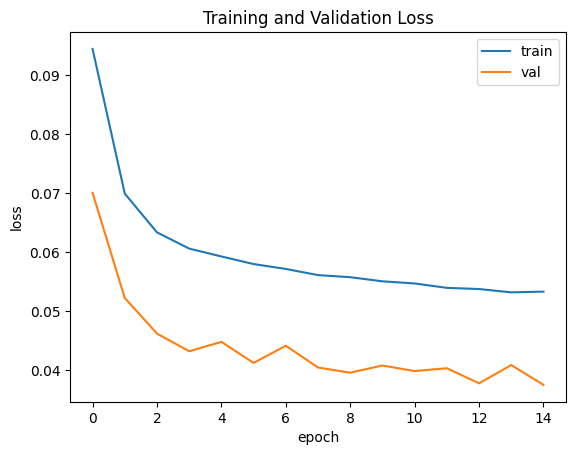

In [ ]:
plot_history(history.history)

625/625 [==============================] - 2s 2ms/step


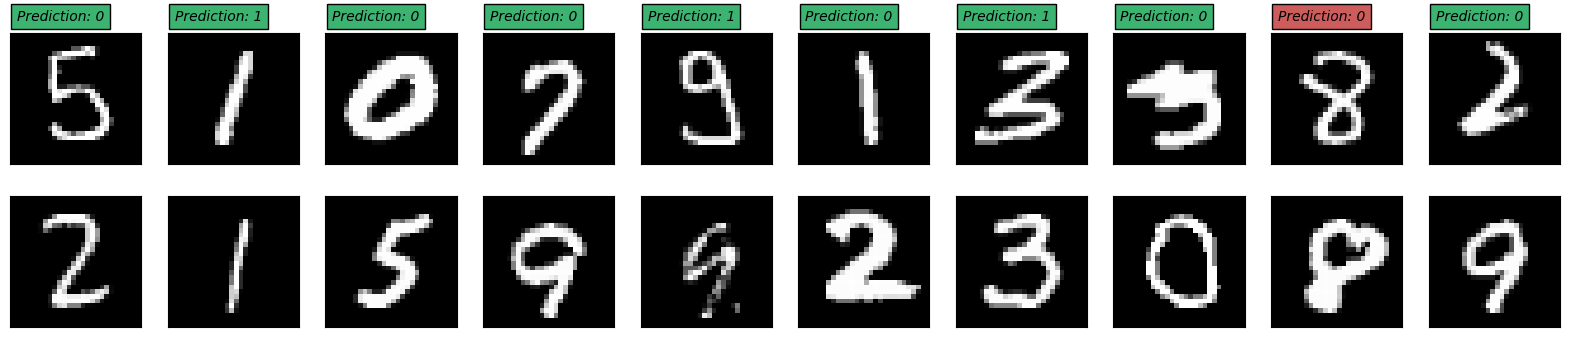


Accuracy: 0.9247499704360962


In [ ]:
predictions = np.round(1 - model.predict([x_pairs_test[:, 0], x_pairs_test[:, 1]]))
display_pairs(x_pairs_test, predictions, predictions == y_pairs_test)

accuracy = metrics.BinaryAccuracy()
accuracy.update_state(y_pairs_test, predictions)
print(f"\nAccuracy: {accuracy.result().numpy()}")